# Desafio 1 - Maratona Behind the Code 2021

### Notebook guia

Esse Jupyter Notebook te dará instruções para criar uma solução introdutória para o desafio 1 da Maratona. Sinta-se livre para editar e melhorar sua solução!


**Atenção: se estiver utilizando o Watson Studio, lembre-se de deixar o Notebook como editável, clicando no botão de editar acima.**

![](https://s3.br-sao.cloud-object-storage.appdomain.cloud/maratona-static/edit-notebook.png)

## Exploração do dataset

O primeiro passo para o desenvolvimento de um bom modelo de Machine Learning é explorar bem os dados que temos para trabalhar. Devemos entender o melhor possível a relevância de cada dado para o valor que queremos predizer. Afinal, a predição do modelo é inteiramente baseada nos dados com que treinou.

Existem muitas bibliotecas em Python que podem ser utilizadas para tratamento e visualização de dados. Nesses exemplos, vamos usar Pandas, Seaborn e Matplotlib.

In [91]:

# identificando os outliers para as variáveis
def limite_quantile_outliers(data, col):
    # primeiro quartil (q1)
    q1 = data[col].quantile(.25)
    # terceiro quartil (q3)
    q3 = data[col].quantile(.75)
    # cálculo do IQR (AMPLITUDE INTERQUARTIL)
    IQR = q3 - q1

    print(f'IQR da variável {col}: ', IQR)

    # definindo os limites

    # limite superior é +1.5 vezes o valor do IQR
    sup = q3 + 1.5 * IQR
    # limite inferior é -1.5 vezes o valor do IQR
    inf = q1 - 1.5 * IQR

    print(f'Limite superior de {col}: ', sup)
    print(f'Limite inferior de {col}: ', inf)


def boxplot_outliers(data, col, val):
    # Visulizando o boxplot da coluna price
    fig, ax = plt.subplots(figsize=(15, 3))
    data[col].plot(kind='box', vert=False)
    ax.set_title(f'Dataset - {col}')
    plt.show()
    print("O dataset possui {} colunas".format(data.shape[0]))
    print("{} Entradas acima de {}".format(len(data[data[col] > val]), val))
    print("Representam {:.2f}% do dataset".format(
        (len(data[data[col] > val]) / data.shape[0])*100))

def encoder_ohe(cols_ohe, ohe, X_train, X_val):
    for col in cols_ohe:
        colunas_ohe = ohe.fit_transform(X_train[[col]])
        colunas_ohe_teste = ohe.transform(X_val[[col]])
        
        categorias_ohe = ohe.categories_[0]
        
        for indice, nome_categoria in enumerate(categorias_ohe):
            df_categorias = pd.DataFrame(data=colunas_ohe[:, indice], columns=[nome_categoria])
            df_categorias_teste = pd.DataFrame(data=colunas_ohe_teste[:, indice], columns=[nome_categoria])
            
            
            X_train[nome_categoria] = colunas_ohe[:, indice]
            X_val[nome_categoria] = colunas_ohe_teste[:, indice]
        
    
        X_train = X_train.drop(col, axis=1)
        X_val = X_val.drop(col, axis=1)

    return X_train, X_val

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from sklearn.ensemble import ExtraTreesRegressor

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier


from imblearn.over_sampling import SMOTE


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.0f}'.format

import warnings
warnings.filterwarnings("ignore")


Primeiramente, vamos carregar o dataset do desafio neste Notebook. Vamos começar com o principal, `LOANS.csv`. Para isso, podemos usar o ícone de assets, disponível no canto superior direito da tela, e inserir o dataset como um DataFrame Pandas, como na imagem abaixo. 

<img width="300px" src="https://s3.br-sao.cloud-object-storage.appdomain.cloud/maratona-static/load-loans.png" />

Repita para todos os datasets que for utilizar.

In [93]:
# Carregue aqui o dataset
loans = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/LOANS.csv')
accounts = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/ACCOUNTS.csv')
demographics = pd.read_csv(
    '/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Data/DEMOGRAPHICS.csv')

submission = pd.read_csv('https://raw.githubusercontent.com/maratonadev/desafio-1-2021/main/assets/data/ANSWERS.csv')


In [94]:
loans.head(2)


,ID,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW
0,610339,713,STORES,3,CAR_USED,3103,NONE,1
1,109167,341,STORES,1,CAR_NEW,716,NONE,1


In [95]:
accounts.head(2)


,ID,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT
0,291655,-566.53,ALL_CREDITS_PAID_BACK,36.42,1
1,657079,-1673.16,CREDITS_PAID_TO_DATE,22.9,1


In [96]:
demographics.head(2)


,ID,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION
0,24252,M,47,3,1,0,1,14,SAVINGS_INSURANCE,OWN,3
1,1002018,M,19,3,1,0,1,0,SAVINGS_INSURANCE,RENT,2


In [97]:
loans.shape, accounts.shape, demographics.shape


((3999, 8), (2477, 5), (3936, 11))

In [98]:
join_df = pd.merge(loans, accounts, on='ID')
data = pd.merge(join_df, demographics, on='ID')


Renomeie o nome da variável criada com o dataset para `loans`, para ficar de acordo com os códigos abaixo.

Podemos usar os métodos `.info()` e `.describe()` para obter informações básicas sobre quantidade presente dos dados, tipos e valores deles.

In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          2477 non-null   int64  
 1   PAYMENT_TERM                2460 non-null   float64
 2   INSTALLMENT_PLANS           2462 non-null   object 
 3   INSTALLMENT_PERCENT         2459 non-null   float64
 4   LOAN_PURPOSE                2467 non-null   object 
 5   LOAN_AMOUNT                 2466 non-null   float64
 6   OTHERS_ON_LOAN              2464 non-null   object 
 7   ALLOW                       2477 non-null   int64  
 8   CHECKING_BALANCE            2467 non-null   object 
 9   CREDIT_HISTORY              2462 non-null   object 
 10  EXISTING_SAVINGS            2467 non-null   object 
 11  EXISTING_CREDITS_COUNT      2463 non-null   float64
 12  SEX                         2467 non-null   object 
 13  AGE                         2465 

In [100]:
loans.describe()

,ID,PAYMENT_TERM,INSTALLMENT_PERCENT,LOAN_AMOUNT,ALLOW
count,3999,3975,3974,3981,3999
mean,660356,654,3,3479,1
std,372833,339,1,2490,0
min,98,120,1,250,0
25%,341846,390,2,1330,0
50%,667061,651,3,3237,1
75%,977874,899,4,5334,1
max,1320082,1984,6,11676,1


A variável destino para este desafio é a `ALLOW`, significando se um empréstimo deverá ser permitido ou não, baseado nas informações dadas. Vamos dar uma olhada em como está a distribuição dessa variável

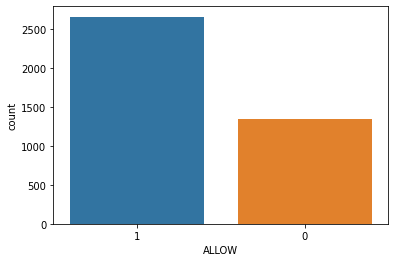

In [101]:
risk_plot = sns.countplot(data=loans, x='ALLOW',
                          order=loans['ALLOW'].value_counts().index)
plt.show()

Sinta-se livre para ver a distribuição de outras colunas do conjunto de dados, utilizar os outros conjuntos de dados, explorar as correlações entre variáveis e outros.

## Tratamento dos dados

Uma vez que exploramos os dados, entendemos a importância de cada coluna e podemos fazer alterações nelas para para obter um melhor resultado. Aqui, vamos fazer apenas um tratamento simples, de remover do dataset as linhas que tiverem faltando algum valor. Não necessariamente essa técnica é a melhor para se utilizar no desafio, é apenas um exemplo de como tratar o dataset.

Para tratamentos mais avançados, como modificação de colunas ou criação de novas colunas, veja mais abaixo no Notebook, em que explicamos como utilizar as `Pipelines`, da biblioteca `sklearn`, para realizar transformações nos dados.

In [103]:
# clean_df = loans.dropna()
# clean_df.count()

Podemos observar que agora temos um dataset "limpo", mas perdemos alguns dados por remover as linhas em que pelo menos uma coluna estava faltando.

Observando a execução do método `.info()` acima, podemos ver que existem três colunas do tipo `object`. O modelo do `scikit-learn` que vamos usar não é capaz de processar uma variável desse tipo. Portanto, para dar seguimento ao experimento, vamos remover essa coluna. Recomendamos que você use alguma técnica para tratamento de variáveis categóricas, como o _one-hot encoding_, em vez de remover a coluna.

Vamos também remover a coluna `ID`, pois sabemos que ela não é uma informação útil para a predição (é apenas um número identificando um cliente).

## Criação do modelo

Com os dados prontos, podemos selecionar um modelo de Machine Learning para treinar com nossos dados. Nesse exemplo, vamos utilizar um modelo de classificação básico, o de Árvore de Decisão.

Para conseguir avaliar o desempenho do nosso modelo, vamos dividir os dados que temos entre dados de treino e de teste, e assim, após o treinamento, verificar como ele está se saindo com as predições.

Abaixo, separamos os dados que queremos predizer dos dados que utilizamos como informações para a predição.

In [104]:
data.head(2)

,ID,PAYMENT_TERM,INSTALLMENT_PLANS,INSTALLMENT_PERCENT,LOAN_PURPOSE,LOAN_AMOUNT,OTHERS_ON_LOAN,ALLOW,CHECKING_BALANCE,CREDIT_HISTORY,EXISTING_SAVINGS,EXISTING_CREDITS_COUNT,SEX,AGE,JOB_TYPE,DEPENDENTS,TELEPHONE,FOREIGN_WORKER,EMPLOYMENT_DURATION,PROPERTY,HOUSING,CURRENT_RESIDENCE_DURATION
0,291655,310,NONE,2,CAR_NEW,3503,NONE,1,-566.53,ALL_CREDITS_PAID_BACK,36.42,1,F,24,3,1,1,1,0,SAVINGS_INSURANCE,OWN,2
1,657079,630,STORES,3,CAR_NEW,3729,NONE,1,-1673.16,CREDITS_PAID_TO_DATE,22.9,1,F,30,3,1,0,1,5,CAR_OTHER,RENT,1


In [105]:
def no_checking(x): return 0 if x == 'NO_CHECKING' else x
def existing_savings(x): return 0 if x == 'UNKNOWN' else x


In [106]:
data['CHECKING_BALANCE'] = data['CHECKING_BALANCE'].apply(no_checking)
data['EXISTING_SAVINGS'] = data['EXISTING_SAVINGS'].apply(existing_savings)
data['CHECKING_BALANCE'] = data['CHECKING_BALANCE'].astype(float)
data['EXISTING_SAVINGS'] = data['EXISTING_SAVINGS'].astype(float)


# Removendo outliers

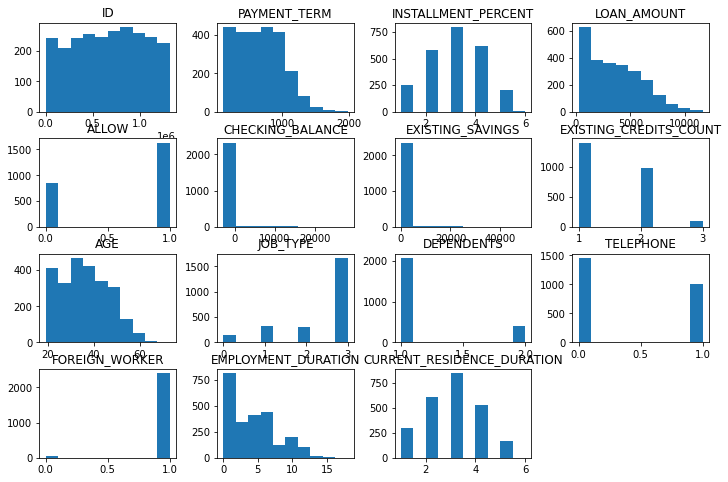

In [107]:
features_number = data.select_dtypes(include=['number']).columns

data[features_number].hist(figsize=(12, 8), grid=False);

In [108]:
features_analysis = ['PAYMENT_TERM', 'LOAN_AMOUNT',
                     'CHECKING_BALANCE', 'EXISTING_SAVINGS']

for col in features_analysis:
    print(col)
    limite_quantile_outliers(data, col)
    print('\n')


PAYMENT_TERM
IQR da variável PAYMENT_TERM:  510.0
Limite superior de PAYMENT_TERM:  1665.0
Limite inferior de PAYMENT_TERM:  -375.0


LOAN_AMOUNT
IQR da variável LOAN_AMOUNT:  3931.0
Limite superior de LOAN_AMOUNT:  11176.75
Limite inferior de LOAN_AMOUNT:  -4547.25


CHECKING_BALANCE
IQR da variável CHECKING_BALANCE:  78.295
Limite superior de CHECKING_BALANCE:  154.4825
Limite inferior de CHECKING_BALANCE:  -158.6975


EXISTING_SAVINGS
IQR da variável EXISTING_SAVINGS:  646.5450000000001
Limite superior de EXISTING_SAVINGS:  1665.1325000000002
Limite inferior de EXISTING_SAVINGS:  -921.0475000000001




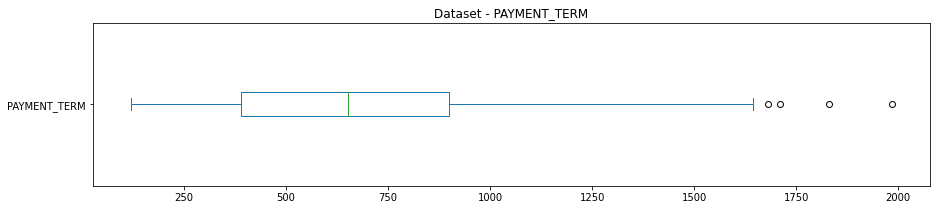

O dataset possui 2477 colunas
4 Entradas acima de 1665.0
Representam 0.16% do dataset


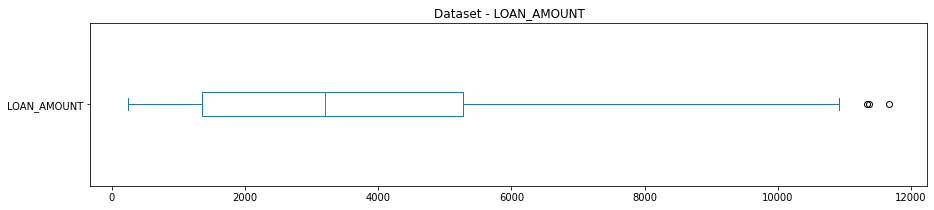

O dataset possui 2477 colunas
3 Entradas acima de 11176.75
Representam 0.12% do dataset


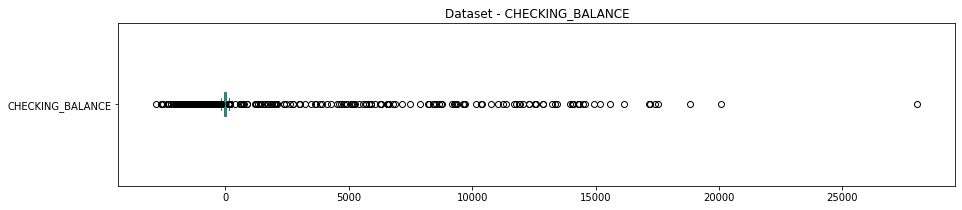

O dataset possui 2477 colunas
254 Entradas acima de 154.4825
Representam 10.25% do dataset


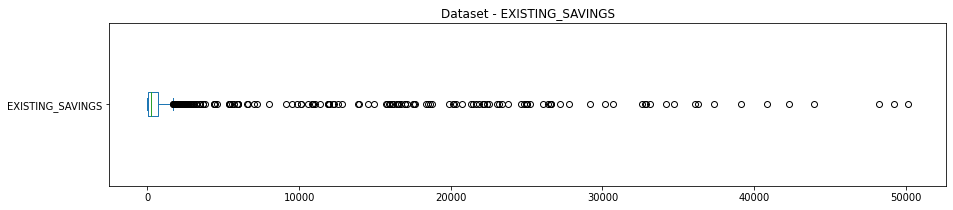

O dataset possui 2477 colunas
199 Entradas acima de 1665.1326
Representam 8.03% do dataset


In [109]:
valores_superior = [1665.0, 11176.75, 154.4825, 1665.1326]
for (col, val) in zip(features_analysis, valores_superior):
    boxplot_outliers(data, col, val)


# Limpando os outliers

In [110]:
features_analysis


['PAYMENT_TERM', 'LOAN_AMOUNT', 'CHECKING_BALANCE', 'EXISTING_SAVINGS']

In [111]:
df = data.drop(data[(data['CHECKING_BALANCE'] >= 1000) | (data['EXISTING_SAVINGS'] >= 3000)].index, axis=0)
print('Foram retiradas {} linhas'.format(data.shape[0] - df.shape[0]))


Foram retiradas 252 linhas


# Divisao dos dados

In [135]:
df.isna().sum()
df = df.dropna(axis=0)

In [136]:
X = df.drop(['ALLOW'], axis=1)
y = df['ALLOW']


In [159]:
test_pct = 0.2  # Separaremos 30% dos dados para testes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_pct, random_state=42)


In [160]:
from imblearn.over_sampling import SMOTENC

<AxesSubplot:>

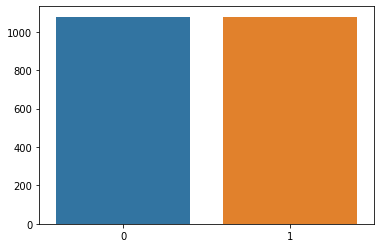

In [161]:
smote = SMOTENC(random_state=42, categorical_features=[2, 4, 6, 8, 11, 18, 19])

X_over, y_over = smote.fit_sample(X_train, y_train)

sns.barplot(y_over.value_counts().index, y_over.value_counts().values)

# Realizando o tratamento dos dados

In [151]:
object_features = X_train.select_dtypes(include=['object']).columns

for col in object_features:
    print(col, ' - ', X_train[col].unique())


INSTALLMENT_PLANS  -  ['NONE' 'STORES' 'BANK']
LOAN_PURPOSE  -  ['CAR_USED' 'FURNITURE' 'OTHER' 'REPAIRS' 'RADIO_TV' 'APPLIANCES'
 'CAR_NEW' 'EDUCATION' 'RETRAINING' 'VACATION' 'BUSINESS']
OTHERS_ON_LOAN  -  ['NONE' 'CO-APPLICANT' 'GUARANTOR']
CREDIT_HISTORY  -  ['CREDITS_PAID_TO_DATE' 'PRIOR_PAYMENTS_DELAYED' 'OUTSTANDING_CREDIT'
 'ALL_CREDITS_PAID_BACK' 'NO_CREDITS']
SEX  -  ['F' 'M']
PROPERTY  -  ['CAR_OTHER' 'SAVINGS_INSURANCE' 'UNKNOWN' 'REAL_ESTATE']
HOUSING  -  ['RENT' 'OWN' 'FREE']


# Criando Baseline

In [152]:
from sklearn.base import BaseEstimator, TransformerMixin


class EncoderCredit(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fill(self, x):
        return 0 if (x == 'NO_CHECKING') | (x == 'UNKNOWN') else x

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X[self.col[0]] = X[self.col[0]].apply(self.fill).astype(float)
        X[self.col[1]] = X[self.col[1]].apply(self.fill).astype(float)
        return X


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Primeiro realizamos a cópia do DataFrame 'X' de entrada
        data = X.copy()
        # Retornamos um novo dataframe sem as colunas indesejadas
        return data.drop(labels=self.columns, axis='columns')


In [162]:
X_over = X_over[submission.columns[:-1]]
X_val = X_val[submission.columns[:-1]]
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1605, 21), (402, 21), (1605,), (402,))

In [163]:
categorical_columns = ['LOAN_PURPOSE', 'CREDIT_HISTORY', 'PROPERTY',
                       'INSTALLMENT_PLANS', 'OTHERS_ON_LOAN', 'SEX', 'HOUSING']
encoder_credit = ['CHECKING_BALANCE', 'EXISTING_SAVINGS']

# cols_scaler = ['PAYMENT_TERM', 'INSTALLMENT_PERCENT', 'LOAN_AMOUNT', 'CHECKING_BALANCE', 'EXISTING_SAVINGS',
#                'EXISTING_CREDITS_COUNT', 'AGE', 'JOB_TYPE', 'DEPENDENTS', 'EMPLOYMENT_DURATION', 'CURRENT_RESIDENCE_DURATION']

columnTransformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    remainder='passthrough')

pipe_features = Pipeline([('drop', DropColumns('ID')),
                          ('fill', EncoderCredit(encoder_credit))])


# Criando o modelo

In [164]:
# pipe = Pipeline([
#     ('fill', pipe_features),
#     ('transformer', columnTransformer),
#     ('model',  KerasClassifier(FeedForward, epochs=100, batch_size=10, verbose=0))
# ])

pipe = Pipeline([
    ('fill', pipe_features),
    ('transformer', columnTransformer),
    ('model',  LGBMClassifier(n_estimators=500, learning_rate=0.1, num_leaves=5,))
])

In [165]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(pipe, X_over, y_over, cv=cv)

array([0.8287037 , 0.81481481, 0.8587963 , 0.85614849, 0.83526682])

In [166]:
pipe.fit(X_over, y_over)

pipe.score(X_val, y_val)

0.763681592039801

In [167]:
# pipe.score(X_val, y_val)
y_pred = pipe.predict(X_val)
# y_pred = (y_pred > 0.5)

In [168]:
# y_pred = pipe.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Acurácia do modelo (número de predições assertivas sobre número total de testes): {acc}")


Acurácia do modelo (número de predições assertivas sobre número total de testes): 0.763681592039801


              precision    recall  f1-score   support

           0       0.62      0.60      0.61       124
           1       0.82      0.84      0.83       278

    accuracy                           0.76       402
   macro avg       0.72      0.72      0.72       402
weighted avg       0.76      0.76      0.76       402



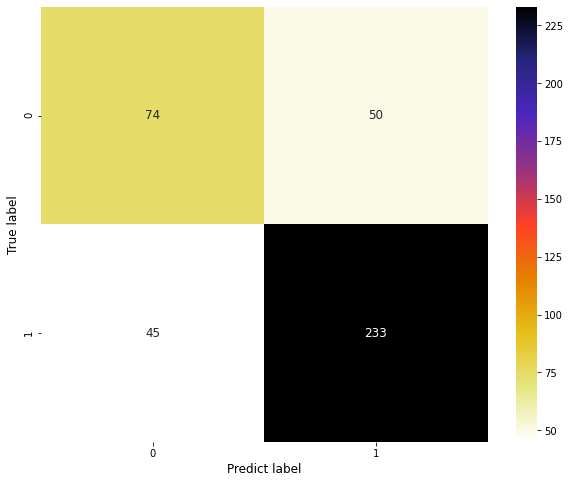

In [169]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

In [170]:
pred = pipe.predict(submission)

In [171]:
submission['ALLOW'] = pred

In [172]:
submission.to_csv('/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/01_Bantotal/Submission/submission.csv', index=False)

# Tuning hyperparameters

In [67]:
from skopt import BayesSearchCV

In [68]:
grid_params = {'model__learning_rate': [0.01], 'model__n_estimators': [8, 24, 50, 100, 500, 2000],
                   'model__num_leaves': [6, 8, 12, 16, 20], 'model__boosting_type': ['gbdt'], 
                   'model__seed': [500],
                   'model__colsample_bytree': [0.65, 0.75, 0.8], 
                   'model__subsample': [0.7, 0.75, 0.8], 'model__reg_alpha': [1, 2, 6],
                   'model__reg_lambda': [1, 2, 6]}

In [72]:
model_tune = BayesSearchCV(pipe, [(grid_params, 20)], n_jobs=-1, cv=cv, n_iter=5, random_state=42)

In [76]:
model_tune.fit(X_over, y_over)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('fill',
                                         Pipeline(steps=[('drop',
                                                          DropColumns(columns='ID')),
                                                         ('fill',
                                                          EncoderCredit(col=['CHECKING_BALANCE',
                                                                             'EXISTING_SAVINGS']))])),
                                        ('transformer',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('onehotencoder',
                                                                          OneHotEncoder(),
                                                                          ['LOAN_PURPOSE',...
                                        

In [77]:
model_tune

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('fill',
                                         Pipeline(steps=[('drop',
                                                          DropColumns(columns='ID')),
                                                         ('fill',
                                                          EncoderCredit(col=['CHECKING_BALANCE',
                                                                             'EXISTING_SAVINGS']))])),
                                        ('transformer',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('onehotencoder',
                                                                          OneHotEncoder(),
                                                                          ['LOAN_PURPOSE',...
                                        

In [79]:
model_tune.best_params_

OrderedDict([('model__boosting_type', 'gbdt'),
             ('model__colsample_bytree', 0.8),
             ('model__learning_rate', 0.01),
             ('model__n_estimators', 500),
             ('model__num_leaves', 16),
             ('model__reg_alpha', 1),
             ('model__reg_lambda', 1),
             ('model__seed', 500),
             ('model__subsample', 0.7317864550939585)])

In [80]:
model_tune.score(X_val, y_val)

0.7728026533996684

In [ ]:
y_pred = model_tune.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       170
           1       0.85      0.86      0.85       382

    accuracy                           0.79       552
   macro avg       0.76      0.75      0.76       552
weighted avg       0.79      0.79      0.79       552



Apesar de estarmos utilizando somente algumas variáveis do dataset carregado, o desafio espera um modelo que aceite todas as variáveis dos conjuntos de dados disponíveis. Portanto, vamos utilizar um transformador para transformar os dados de entrada, removendo as colunas que não queremos, antes enviá-los ao nosso modelo. Dessa forma, criaremos uma `Pipeline`, que utiliza o transformador como entrada, e o nosso modelo em seguida.

Fica como tarefa para você unir os outros conjuntos de dados disponíveis e utilizá-los também para predições no modelo, em vez de remover as colunas.

## Sobre Pipelines

Uma `Pipeline`, da biblioteca `scikit-learn`, consiste em uma série de passos onde realizamos transformações em dados. As transformações são definidas por classes que devem ter sempre **dois métodos**:

- **fit**: Um método que recebe dados de treinamento, e retorna a própria instância da classe. Ele é aplicado quando se vai treinar utilizar uma Pipeline para treinar um modelo.
- **transform**: Um método que recebe como entrada um conjunto de dados e deve retornar um outro conjunto de dados, transformado. Ele é aplicado em cada etapa da Pipeline, recebendo os dados do passo anterior e transformando-os.

Veja abaixo uma representação gráfica do funcionamento de uma Pipeline:

![](https://s3.br-sao.cloud-object-storage.appdomain.cloud/maratona-static/pipeline.png)

Nesse Notebook, vamos criar uma Pipeline muito similar ao exemplo acima, com dois estágios:

- **drop_columns**: Remove as colunas indesejadas do conjunto de dados de entrada.
- **classification**: Alimenta um modelo de classificação com os dados obtidos no estágio **drop_columns**, podendo ser tanto para treinamento quanto para obter uma predição.

## Criação de Pipelines no scikit-learn

Para criar um modelo capaz de fazer transformações nos dados de entrada, vamos criar uma `Pipeline` do `scikit-learn` e aplicar nossas transformações dentro dos estágios dela.

Abaixo, definimos um transformador exemplo, que irá remover as colunas passadas como parâmetro em sua inicialização:

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline


# # Um transformador para remover colunas indesejadas
# class DropColumns(BaseEstimator, TransformerMixin):
#     def __init__(self, columns):
#         self.columns = columns

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Primeiro realizamos a cópia do DataFrame 'X' de entrada
#         data = X.copy()
#         # Retornamos um novo dataframe sem as colunas indesejadas
#         return data.drop(labels=self.columns, axis='columns')


Tanto o método `fit` quanto o `transform` devem obrigatoriamente ser definidos, mesmo se não forem fazer nada de diferente, como no caso do `fit` acima.

Da mesma forma, você pode criar outros transformadores, para outros propósitos, sempre herdando das classes `BaseEstimator` e `TransformerMixin`. Você pode utilizar um transformador para, por exemplo, criar novas colunas, editar tipos de dados de colunas existentes, entre outros.

Agora, vamos criar uma Pipeline para utilização do nosso modelo, aceitando todas as colunas esperadas pelo desafio e removendo as que não queremos usar.

In [ ]:
# challenge_columns = ['ID', 'CHECKING_BALANCE', 'PAYMENT_TERM', 'CREDIT_HISTORY',
#        'LOAN_PURPOSE', 'LOAN_AMOUNT', 'EXISTING_SAVINGS',
#        'EMPLOYMENT_DURATION', 'INSTALLMENT_PERCENT', 'SEX', 'OTHERS_ON_LOAN',
#        'CURRENT_RESIDENCE_DURATION', 'PROPERTY', 'AGE', 'INSTALLMENT_PLANS',
#        'HOUSING', 'EXISTING_CREDITS_COUNT', 'JOB_TYPE', 'DEPENDENTS',
#        'TELEPHONE', 'FOREIGN_WORKER', 'ALLOW']

# unwanted_columns = list((set(challenge_columns) - set(target)) - set(features)) # Remover todas as colunas que não são features do nosso modelo


In [ ]:
# # Criando uma instância do transformador, passando como parâmetro as colunas que não queremos
# drop_columns = DropColumns(unwanted_columns)


# # Criando a Pipeline, adicionando o nosso transformador seguido de um modelo de árvore de decisão
# skl_pipeline = Pipeline(steps=[('drop_columns', drop_columns), ('classification', model)])


Pronto! Essa pipeline agora está pronta para receber todas as variáveis do desafio, apesar de o modelo só usar algumas.

## Deploy do modelo para o Watson Machine Learning (WML)

Agora temos o modelo pronto para publicação, queremos deixá-lo online para que o sistema da Maratona possa testá-lo :)

Para isso, vamos utilizar a biblioteca `IBM Watson Machine Learning`, que permite realizar o encapsulamento de modelos de Machine Learning em APIs REST.


In [ ]:
# Instalar a biblioteca do WML
# !pip install -U ibm-watson-machine-learning


In [ ]:
from ibm_watson_machine_learning import APIClient


Caso ainda não tiver criado, crie um serviço de Machine Learning aqui: https://cloud.ibm.com/catalog/services/machine-learning.

Insira suas credenciais para o serviço na célula abaixo.

Em `location`, insira o ID da região onde se encontra o seu serviço WML instanciado, de acordo com as possibilidades abaixo:

- Dallas - `us-south`
- London - `eu-gb`
- Frankfurt - `eu-de`
- Tokyo - `jp-tok`

Para a API key, você deve gerá-la aqui: https://cloud.ibm.com/iam/apikeys. Não compartilhe-a com ninguém! Uma API key dá acesso à sua conta IBM Cloud.

In [ ]:
api_key = 'INSIRA SUA API KEY AQUI'
location = 'us-south'  # Caso o WML estiver em uma região diferente, altere

wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

client = APIClient(wml_credentials)


Crie um espaço para salvar o seu modelo. Você pode criá-lo aqui: https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas

Quando criar o seu espaço, **associe a instância do seu serviço WML ao espaço!** Sem associar, você não conseguirá efetuar o deploy.

In [ ]:
# Listar espaços criados na sua instância de WML
client.spaces.list(limit=10)


Copie o ID do seu espaço criado para o desafio e cole-o abaixo para utilizá-lo. Você deverá ver a mensagem 'SUCCESS' se o espaço estiver corretamente configurado.

In [ ]:
space_id = 'cole aqui'
client.set.default_space(space_id)


## Utilização da Pipeline dentro do Watson Machine Learning (WML)

Para utilizar uma Pipeline no WML com transformadores customizados, são necessários alguns passos adicionais:

1. Criar um pacote no Python contendo o transformador customizado;
2. Carregar esse pacote com o transformador em um repositório no WML;
3. Criar uma especificação de software, com esse pacote customizado, que vai ser utilizada como tempo de execução do modelo no WML.

Como exemplo, vamos utilizar um pacote já pronto, disponível aqui: https://github.com/vnderlev/watson-sklearn-transforms. Para configurar o pacote Python, são necessários alguns outros arquivos, mas a lógica do transformador criado se encontra [neste arquivo](https://github.com/vnderlev/watson-sklearn-transforms/blob/master/my_custom_sklearn_transforms/sklearn_transformers.py). No caso, esse é o mesmo transformador que definimos aqui, ele vai excluir do conjunto de dados as colunas passadas como parâmetro na sua inicialização.

Abaixo, vamos baixar esse pacote do GitHub e instalá-lo no Python.

In [ ]:
!rm - rf watson-sklearn-transforms  # Remover a pasta caso já exista
# Clonar o repositório com o pacote
!git clone https: // github.com/vnderlev/watson-sklearn-transforms
!zip - r drop-columns.zip watson-sklearn-transforms  # Zipar o pacote
!pip install drop-columns.zip  # Instalar o pacote zipado


Vamos agora recriar nossa Pipeline utilizando esse pacote instalado.

In [ ]:
from my_custom_sklearn_transforms.sklearn_transformers import DropColumns

drop_columns = DropColumns(unwanted_columns)

pipeline = Pipeline(
    steps=[('drop_columns', drop_columns), ('classification', model)])


Vamos agora subir o transformador customizado que baixamos para o WML.

In [ ]:
# Metadados para o pacote customizado
meta_prop_pkg_extn = {
    client.package_extensions.ConfigurationMetaNames.NAME: "Drop_Columns",
    client.package_extensions.ConfigurationMetaNames.DESCRIPTION: "Extensão para remover colunas",
    client.package_extensions.ConfigurationMetaNames.TYPE: "pip_zip"
}

# Subir o pacote
pkg_extn_details = client.package_extensions.store(
    meta_props=meta_prop_pkg_extn, file_path="drop-columns.zip")

# Salvar as informações sobre o pacote
pkg_extn_uid = client.package_extensions.get_uid(pkg_extn_details)
pkg_extn_url = client.package_extensions.get_href(pkg_extn_details)


Vamos agora criar uma especificação de software com o nosso pacote customizado, para que o WML possa utilizar. Caso estiver utilizando um software diferente de `Python 3.8` ou biblioteca diferente de `scikit-learn`, você pode dar uma olhada na lista de especificações de software suportadas pelo WML: https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-python-types.html?context=analytics&audience=wdp

In [ ]:
base_sw_spec_uid = client.software_specifications.get_uid_by_name(
    "default_py3.8")

# Caso queira utilizar um software diferente de Python 3.8 como base, dê uma olhada nos disponíveis com a linha abaixo
# client.software_specifications.list(limit=100)


In [ ]:
# Metadados da nova especificação de software
meta_prop_sw_spec = {
    client.software_specifications.ConfigurationMetaNames.NAME: "sw_spec_drop_columns",
    client.software_specifications.ConfigurationMetaNames.DESCRIPTION: "Software specification utilizando DropColumns",
    client.software_specifications.ConfigurationMetaNames.BASE_SOFTWARE_SPECIFICATION: {
        "guid": base_sw_spec_uid}
}

# Criando a nova especificação de software e obtendo seu ID
sw_spec_details = client.software_specifications.store(
    meta_props=meta_prop_sw_spec)
sw_spec_uid = client.software_specifications.get_uid(sw_spec_details)

# Adicionando o pacote customizado à nova especificação
client.software_specifications.add_package_extension(sw_spec_uid, pkg_extn_uid)


Finalmente, vamos publicar a pipeline utilizando a especificação de software customizada que criamos.

In [ ]:
# Metadados do modelo
model_props = {
    client.repository.ModelMetaNames.NAME: "Modelo com Pipeline customizada",
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid
}

# Publicando a Pipeline como um modelo
published_model = client.repository.store_model(
    model=pipeline, meta_props=model_props)
published_model_uid = client.repository.get_model_uid(published_model)
client.repository.get_details(published_model_uid)


Seu modelo agora está salvo. Vamos agora deixá-lo disponível online, para que possamos testá-lo:

In [ ]:
# Metadados para publicação do modelo
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Publicação do modelo customizado",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

# Publicar
created_deployment = client.deployments.create(
    published_model_uid, meta_props=metadata)


## Parabéns!

Seu modelo está agora publicado. Quando estiver pronto para submeter o desafio, você pode acessar https://maratona.dev/challenges/1, e utilizar as credenciais abaixo para realizar a submissão. Lembre-se de revisar todas as instruções no [README](https://github.com/maratonadev/desafio-1-2021) antes de submeter!

In [ ]:
deployment_uid = client.deployments.get_uid(created_deployment)

print(
    f"Credenciais para envio (não compartilhe esses dados com ninguém!)\n\nAPI key: {api_key}\nDeployment ID: {deployment_uid}")
